In [2]:
import logging
import os
import pickle
from distutils.dir_util import copy_tree
from pathlib import Path
from dotmap import DotMap

import hydra
import numpy as np
import torch
import matplotlib.pyplot as plt
from omegaconf import DictConfig

import hgp
from hgp.datasets.hamiltonians import load_system_from_name
from hgp.misc.plot_utils import (plot_comparison_traces, plot_learning_curve,
                                 plot_predictions)
from hgp.misc.torch_utils import numpy2torch, torch2numpy
from hgp.misc.train_utils import seed_everything
from hgp.misc.settings import settings

device = settings.device
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

seed_everything(101)


First, we generate some data, in this case we use the Henon-Heiles system, which has Hamiltonian
$$
\mathcal{H}(q_1, q_2, p_1, p_2) = \frac{1}{2}\big(q^2_1+ q^2_2+ p^2_1 +p^2_2\big) + \mu \left(q_2q_1^2-\frac{1}{3}q_2^3\right)
$$

In [4]:
data_config = DotMap(
    {
        "system_name": "henon-heiles", #Name of system, other options are "simple-pendulum" or "spring-pendulum"
        "seed": 1, # Random seed 
        "frequency_train": 4, # Frequency of training data, in Hz
        "frequency_test": 10, # Frequency of test data, in Hz
        "data_obs_T": 40, # Length of training period, seconds
        "data_obs_noise_var": 0.05, # Amount of noise to add
        "noise_rel": True, # Adjust the noise to magnitude of signal
    }
)

system = load_system_from_name(data_config.system_name)(
    frequency_train=data_config.frequency_train,
    T_train=data_config.data_obs_T,
    frequency_test=data_config.frequency_test,
    T_test=2 * data_config.data_obs_T, # Make the test period extend into the future.
    noise_var=data_config.data_obs_noise_var,
    noise_rel=data_config.noise_rel,
    seed=data_config.seed,
    N_x0s=1, # generate a single trajectory
)

# Normalise data
system.scale_ts()
system.scale_ys()

Training data has shape (Number of trajectories, Number of time points, Phase space dimension)

In [5]:
system.trn.ys.shape

(1, 161, 4)

Inspecting the data, we can see that this system exhibits periodic behaviour, with repeating cycles, but also has a chaotic element. 

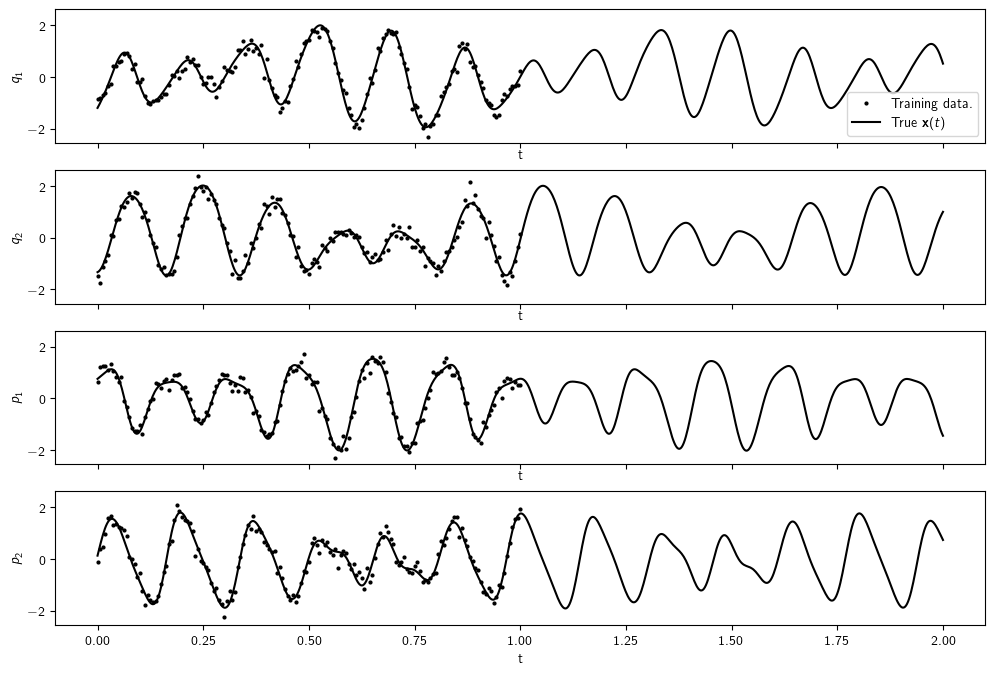

In [6]:
fig, axs = plt.subplots(system.trn.ys.shape[-1], 1, figsize=(12, 8), sharex=True, sharey=True)
coord_labels = ["$q_1$", "$q_2$", "$p_1$", "$p_2$"]
for i in range(system.trn.ys.shape[-1]):
    axs[i].scatter(system.trn.ts, system.trn.ys[0, :, i], s=4, c="k", label="Training data.")
    axs[i].plot(system.tst.ts, system.tst.ys[0, :, i], c="k", label="True $\mathbf{x}(t)$")
    axs[i].set_ylabel(coord_labels[i])
    axs[i].set_xlabel("t")
axs[0].legend()

Next we'll build a HGP, using the energy conserving shooting approach discussed in the paper, and fit the data.

In [7]:
model_config = DotMap(
    {
        "solver": "dopri5", # ODE solver method
        "use_adjoint": False, # Use adjoint for solver backprop

        "eval_samples": 16, # Number of samples to use for model predictions
        "init_noise": 0.1, # Initial value of the noise variance 
        "num_iter": 1000, # number of training iterations
        "lr": 3e-3, # learning rate 
        "log_freq": 100, # logging freqency in training
        "model": {
            "inducing_init": True, # use Hamiltonian aware intialisation
            "num_features": 256, # Number of RFF features for prior 
            "num_inducing": 48, # Number of inducing points 
            "q_diag": False, # Diagonal approximation of inducing variational distribution.
            "shooting": True, # Use shooting 
            "constraint_type": "gauss", # Likelihood type for shooting constriant
            "constraint_trainable": False, # Is shooting constraint trainable 
            "constraint_initial_scale": 1e-3, #Value of shooting constraint
            "constrain_energy": True, # Use energy constrained shooting 
            "energy_constraint_initial_scale": 5e-2, #Value of energy shooting constraint
            "shooting_time_factor": 4, #Use 1 shooting state per 4 datapoints 
            # Factor to make integration points more dense, in this case 4 times as many integration
            # points are used than data points
            "ts_dense_scale": 4,
        },
    }
)

model = hgp.models.builder.build_model(model_config, system.trn.ys)


Fitting model...
Iter 0100 | Loss 1017.30(4727.09) |OBS NLL 0.06(0.14) | XS KL 717.24(3781.72) | E KL 55.59(701.09) |X0 KL 0.04(0.04) | IND KL 243.49(243.30)
Iter 0200 | Loss 342.99(1017.82) |OBS NLL 0.01(0.03) | XS KL 86.47(664.33) | E KL 11.88(108.92) |X0 KL 0.04(0.04) | IND KL 243.56(243.53)
Iter 0300 | Loss 272.17(383.95) |OBS NLL -0.00(0.00) | XS KL 23.56(120.09) | E KL 4.08(19.28) |X0 KL 0.05(0.04) | IND KL 243.42(243.48)
Iter 0400 | Loss 262.05(277.93) |OBS NLL -0.01(-0.01) | XS KL 13.54(27.93) | E KL 4.18(5.57) |X0 KL 0.03(0.04) | IND KL 243.23(243.32)
Iter 0500 | Loss 251.64(257.28) |OBS NLL -0.01(-0.01) | XS KL 5.23(9.94) | E KL 2.30(3.13) |X0 KL 0.04(0.04) | IND KL 243.00(243.11)
Iter 0600 | Loss 250.36(252.16) |OBS NLL -0.01(-0.01) | XS KL 4.39(5.64) | E KL 2.13(2.54) |X0 KL 0.04(0.04) | IND KL 242.74(242.87)
Iter 0700 | Loss 250.48(250.18) |OBS NLL -0.01(-0.01) | XS KL 4.73(4.23) | E KL 2.19(2.25) |X0 KL 0.04(0.04) | IND KL 242.46(242.59)
Iter 0800 | Loss 249.46(249.59) |O

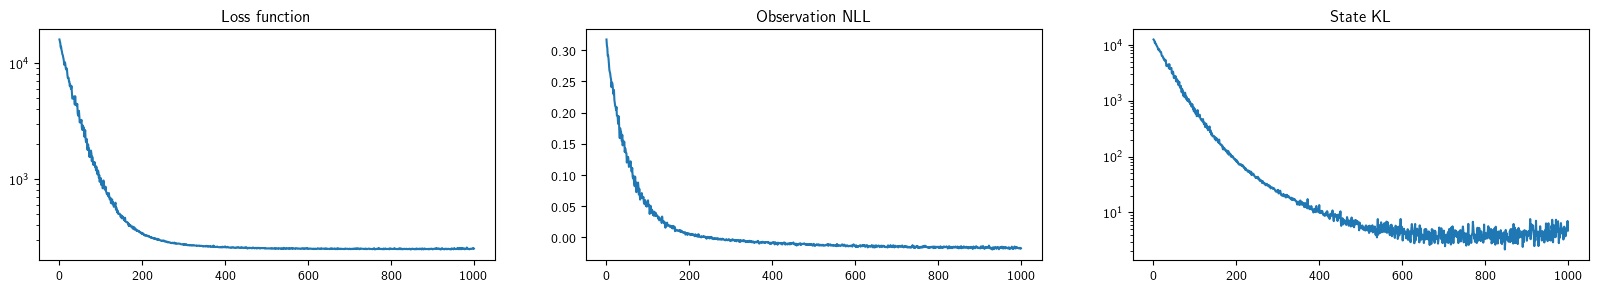

In [8]:
model, history = hgp.models.builder.init_and_fit(
    model, model_config, system.trn.ts, system.trn.ys, return_history=True
)
plot_learning_curve(history)

Now let's make some predictions using the model, and plot them.

In [9]:
preds = hgp.models.builder.compute_predictions(
        model,
        numpy2torch(system.tst.ts),
        eval_sample_size=model_config.eval_samples,
    )

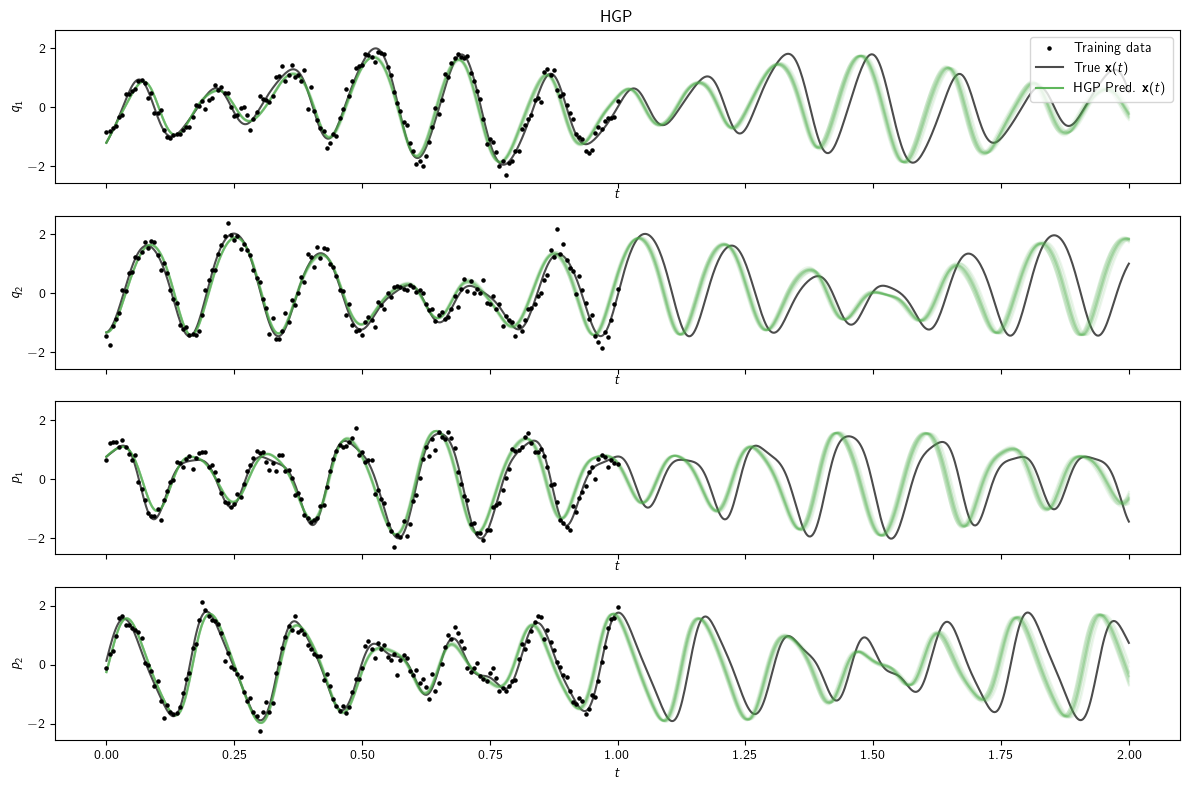

In [10]:
_ = plot_predictions(
    system,
    torch2numpy(preds), model_name="HGP")

In the plot above, each green line is a sample from the model, We can see tha the model is able to extrapolate forward in time reasonably accurately, with uncertainty. 